<a href="https://colab.research.google.com/github/vijayshankarrealdeal/intro_to_pytorch-Gans/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace = True)
               
            )
        else: 
            return nn.Sequential( 
                nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                nn.Tanh()
               
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)



In [ ]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2)
               
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels,output_channels,kernel_size,stride),
                #nn.LeakyReLU(0.2)
               
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [ ]:
num_test = 100
gen = Generator()
disc = Discriminator()
test_images = gen(get_noise(num_test, gen.z_dim))

In [ ]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True , transform=transform),
    batch_size=batch_size,
    shuffle=True)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Step 500: Generator loss: 2.122890001296995, discriminator loss: 0.1598900031745435


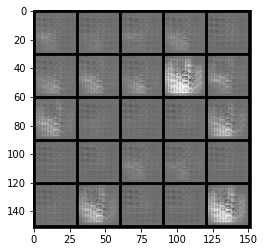

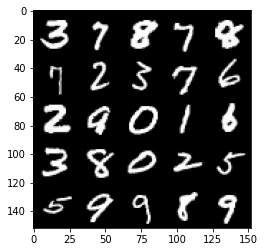

Step 1000: Generator loss: 1.941565823793411, discriminator loss: 0.325633277207613


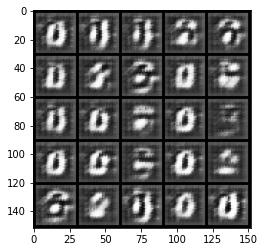

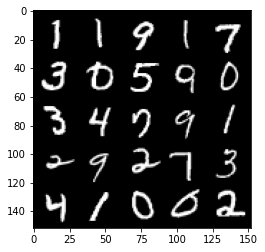

Step 1500: Generator loss: 1.3166715888082983, discriminator loss: 0.49027342069149077


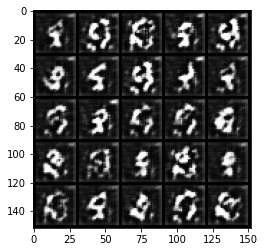

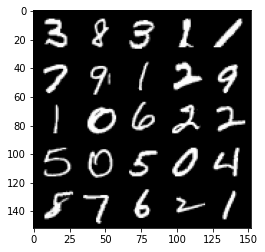

Step 2000: Generator loss: 0.9971465684771534, discriminator loss: 0.5627397937178612


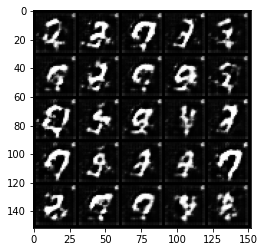

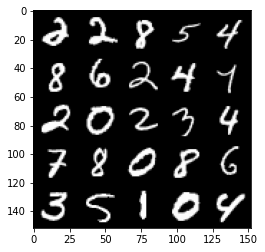

Step 2500: Generator loss: 0.8850909007489686, discriminator loss: 0.5980975664854047


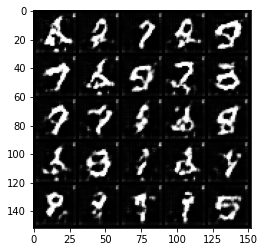

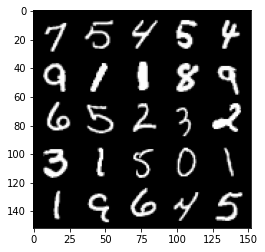

Step 3000: Generator loss: 0.8343257502317432, discriminator loss: 0.6244161595106119


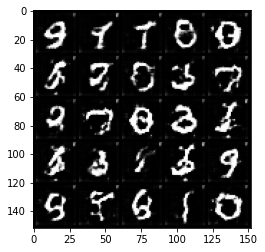

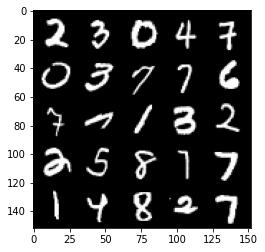

Step 3500: Generator loss: 0.798474568724632, discriminator loss: 0.640338968157768


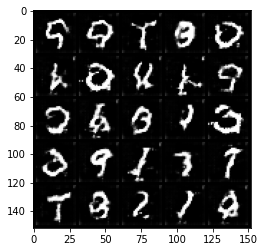

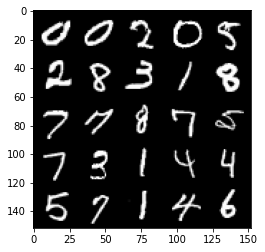

Step 4000: Generator loss: 0.7856931955814369, discriminator loss: 0.650608025312424


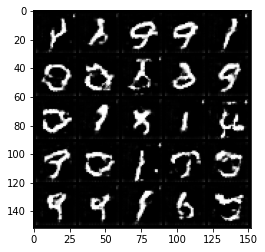

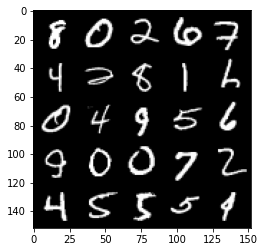

Step 4500: Generator loss: 0.7776631776690482, discriminator loss: 0.6610334811210639


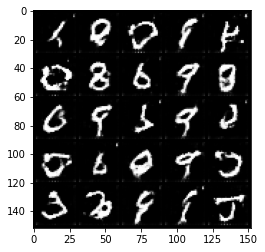

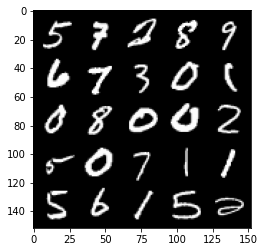

Step 5000: Generator loss: 0.7655394514203072, discriminator loss: 0.6655706590414049


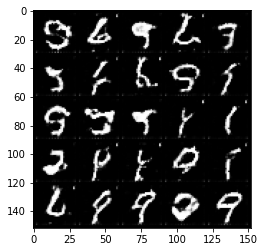

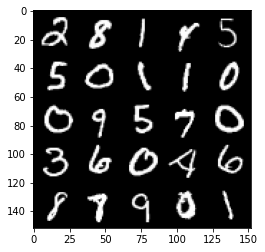

Step 5500: Generator loss: 0.7538349538445472, discriminator loss: 0.672818112015725


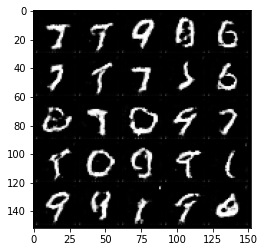

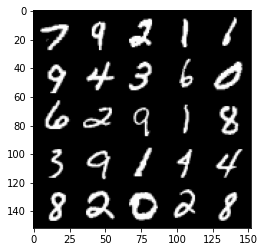

Step 6000: Generator loss: 0.7489879188537595, discriminator loss: 0.6810035107135776


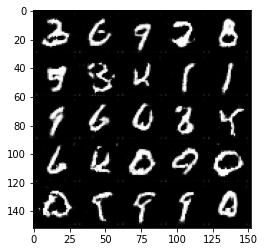

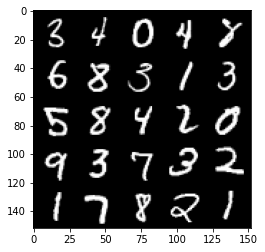

Step 6500: Generator loss: 0.7382137004137043, discriminator loss: 0.684173140645027


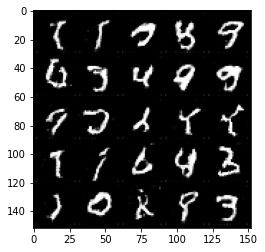

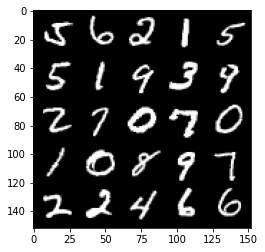

Step 7000: Generator loss: 0.7341495664715769, discriminator loss: 0.6859713116884238


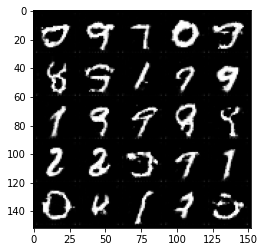

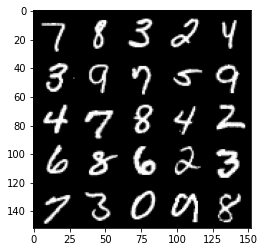

Step 7500: Generator loss: 0.7257168844938281, discriminator loss: 0.6886073324680335


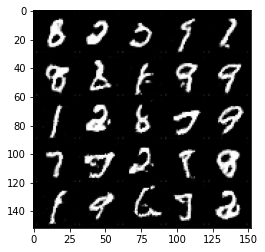

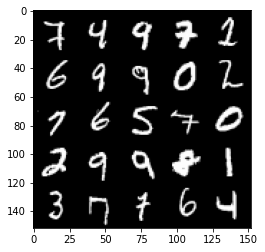

Step 8000: Generator loss: 0.7235912109017371, discriminator loss: 0.6913524050712588


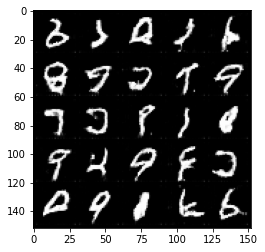

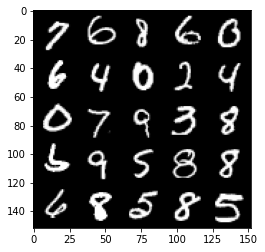

Step 8500: Generator loss: 0.7172259433269497, discriminator loss: 0.6930337723493576


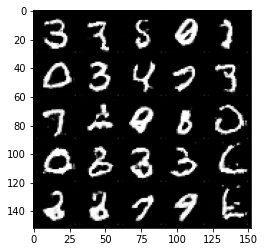

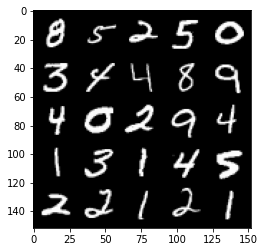

Step 9000: Generator loss: 0.71535636228323, discriminator loss: 0.694186822295189


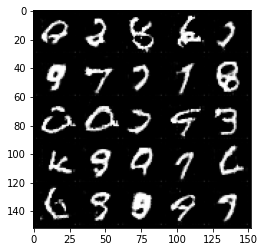

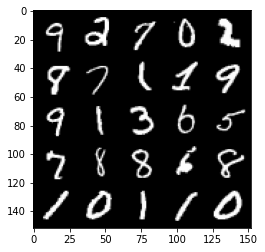

Step 9500: Generator loss: 0.711385522961617, discriminator loss: 0.6947450432777402


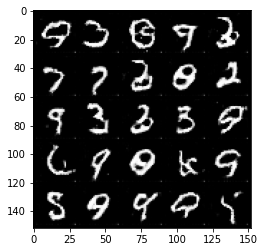

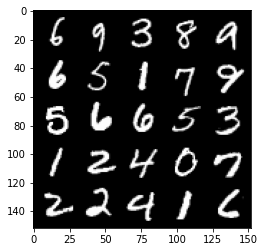

Step 10000: Generator loss: 0.7132038865089408, discriminator loss: 0.6958424702882766


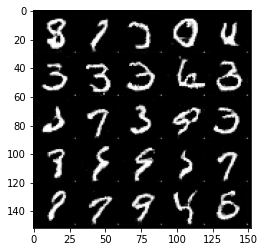

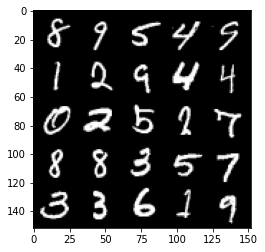

Step 10500: Generator loss: 0.7103235407471651, discriminator loss: 0.6955694850683214


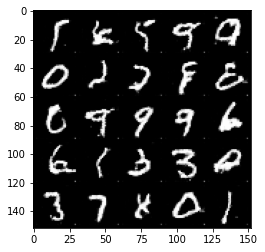

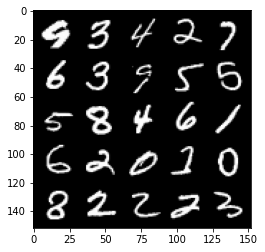

Step 11000: Generator loss: 0.7090681811571115, discriminator loss: 0.6962758356332774


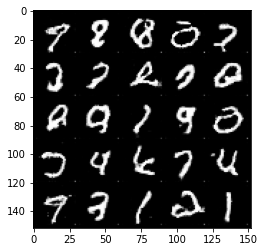

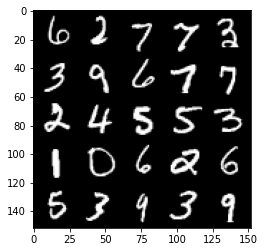

Step 11500: Generator loss: 0.7102603138089173, discriminator loss: 0.6976105974912644


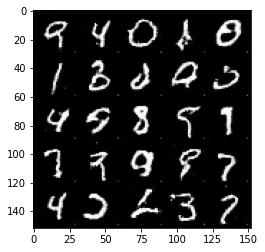

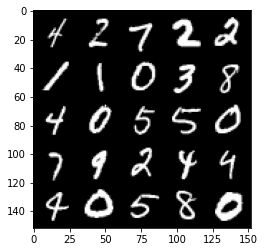

Step 12000: Generator loss: 0.7081404452323915, discriminator loss: 0.6987561639547347


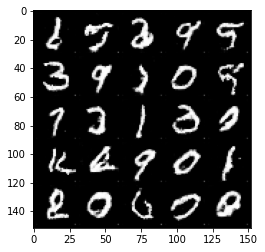

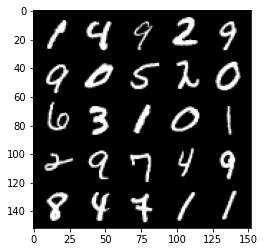

Step 12500: Generator loss: 0.7053786059618001, discriminator loss: 0.6987796988487247


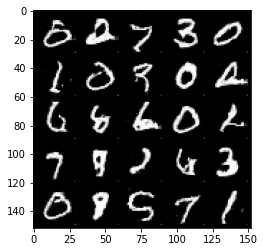

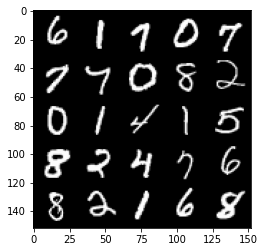

Step 13000: Generator loss: 0.7030954233407966, discriminator loss: 0.6990742824077613


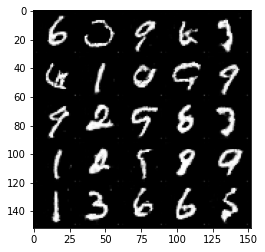

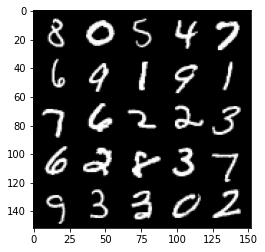

Step 13500: Generator loss: 0.7009795371294024, discriminator loss: 0.6986975462436671


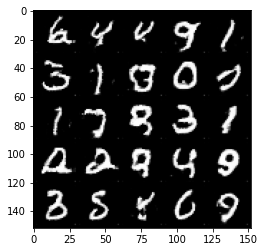

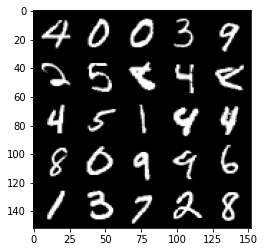

Step 14000: Generator loss: 0.7034307060241703, discriminator loss: 0.6988193128108977


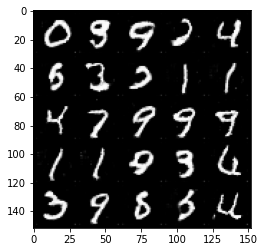

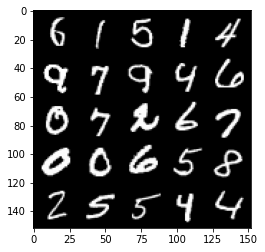

Step 14500: Generator loss: 0.7022368218898783, discriminator loss: 0.6984845060110093


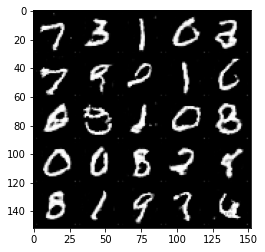

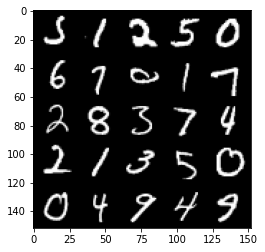

Step 15000: Generator loss: 0.7017416160106654, discriminator loss: 0.6981998274326331


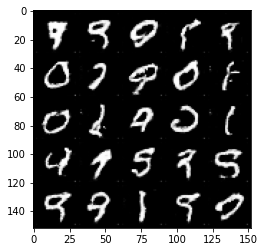

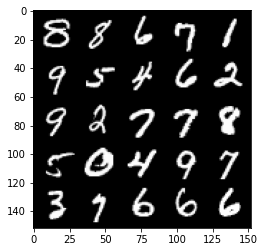

Step 15500: Generator loss: 0.7013877348899846, discriminator loss: 0.6984565393924719


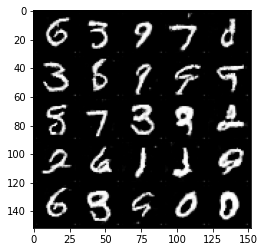

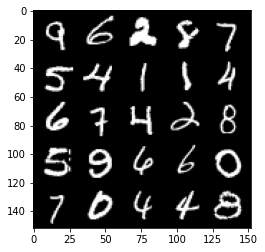

Step 16000: Generator loss: 0.7020395464897151, discriminator loss: 0.6977998621463779


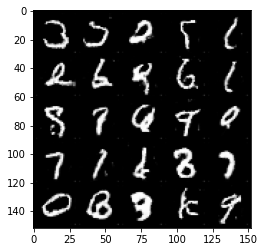

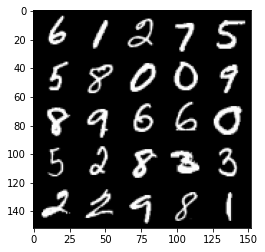

Step 16500: Generator loss: 0.7016964557170868, discriminator loss: 0.6973392330408096


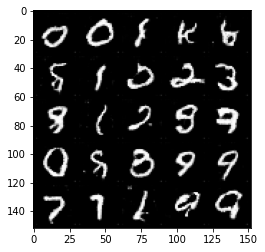

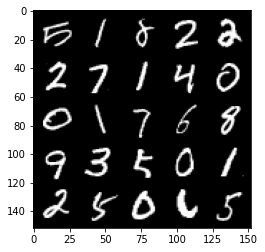

Step 17000: Generator loss: 0.7003198043107983, discriminator loss: 0.6970235363245008


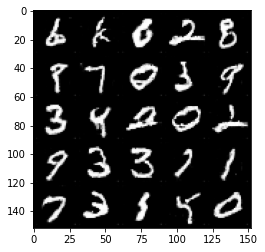

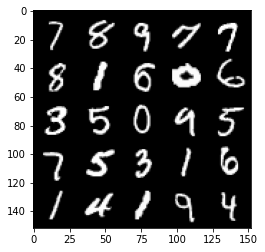

Step 17500: Generator loss: 0.6999187465906143, discriminator loss: 0.6969470125436779


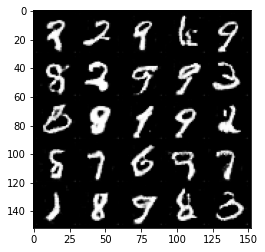

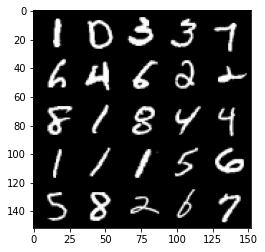

Step 18000: Generator loss: 0.6994548220634463, discriminator loss: 0.6963163307905198


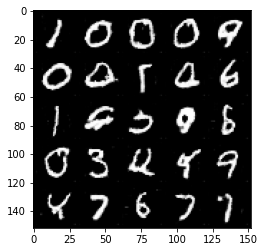

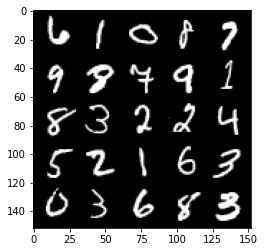

Step 18500: Generator loss: 0.7010357750058178, discriminator loss: 0.6967807533740998


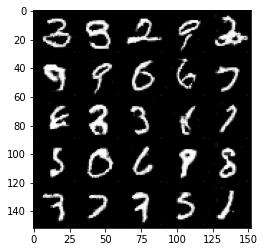

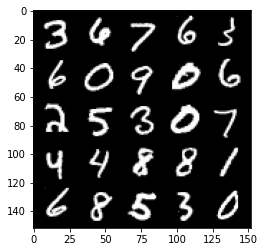

Step 19000: Generator loss: 0.6987835520505906, discriminator loss: 0.6958238711357118


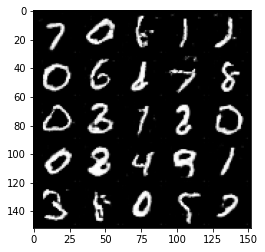

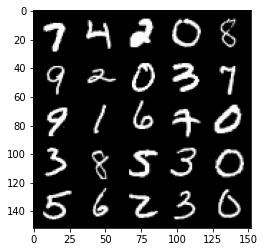

Step 19500: Generator loss: 0.6992299275398249, discriminator loss: 0.6961893802881236


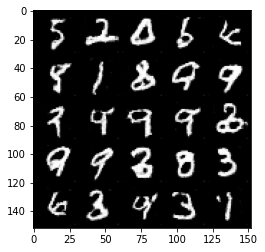

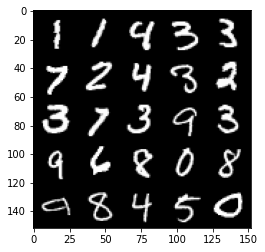

Step 20000: Generator loss: 0.700019603371621, discriminator loss: 0.6961916348934167


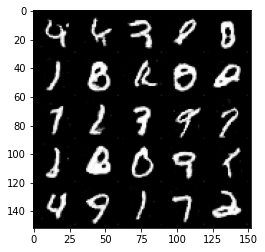

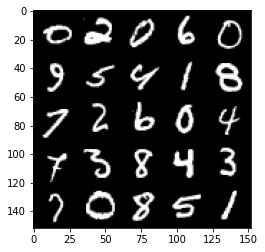

Step 20500: Generator loss: 0.6984628671407703, discriminator loss: 0.6957147705554962


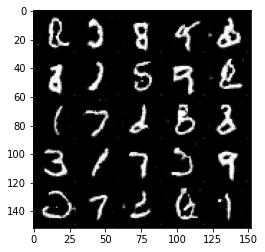

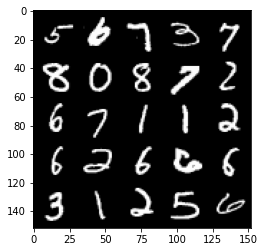

Step 21000: Generator loss: 0.6986897139549256, discriminator loss: 0.6955216486454


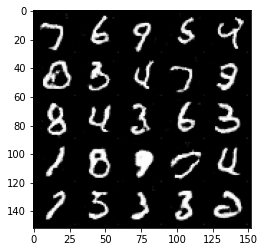

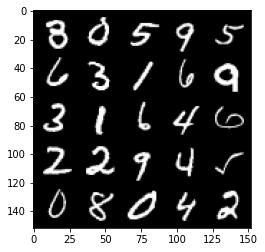

Step 21500: Generator loss: 0.6989725292921073, discriminator loss: 0.6955114601850512


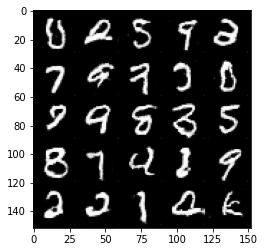

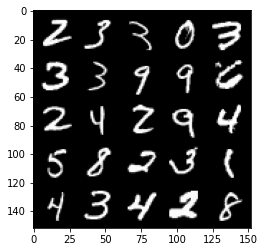

Step 22000: Generator loss: 0.6975472501516344, discriminator loss: 0.6952266933918003


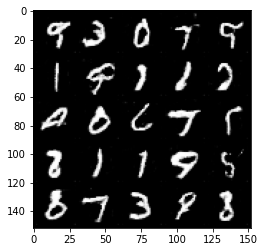

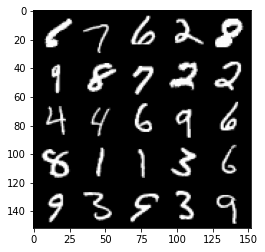

Step 22500: Generator loss: 0.6992355434894567, discriminator loss: 0.6955978689193723


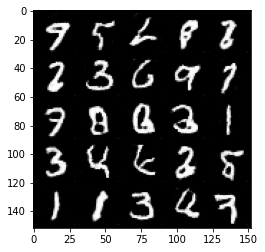

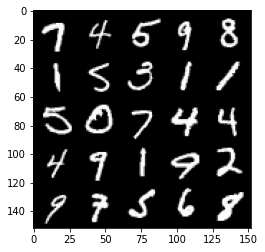

Step 23000: Generator loss: 0.6986807153224935, discriminator loss: 0.6950938028097153


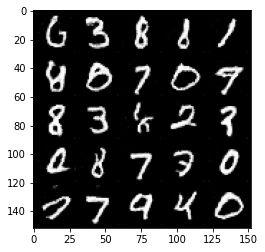

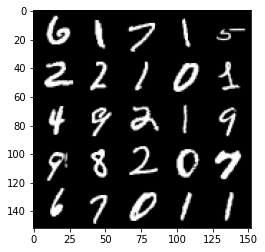

In [ ]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        
        mean_discriminator_loss += disc_loss.item() / display_step
     
        disc_loss.backward(retain_graph=True)
       
        disc_opt.step()

        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

      
        mean_generator_loss += gen_loss.item() / display_step
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
